# Research on the quality of localization of movie titles

The goal of this research is to find out:
* How similar Russian titles and original titles are in general?
* Can we split dissimilar pairs (Russian title::original title) into groups by root cause?

## Importing needed packages

In [1]:
# !pip install sentence-transformers

In [2]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer

In [3]:
from src.title_localization_utils import (
    check_countries,
    get_similarity_dataframe,
    has_numbers_in_square_brackets,
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style="ticks")

In [5]:
SEED = 42

## Paths

In [6]:
relative_path = os.path.join("../", "data", "0_raw_parsed_data")

## Reading data

Let's read the dataset with titles:
* `russian_title` - Russian title
* `original_title` - original title 
* `country` - country of origin

In [7]:
movie_df = pd.read_parquet(
    os.path.join(relative_path, "movies_info.parquet"),
    columns=["russian_title", "original_title", "country"],
)
movie_df.shape

(984, 3)

In [8]:
movie_df

,russian_title,original_title,country
0,12 разгневанных мужчин (1956),12 Angry Men,США
1,Олдбой (2003),Oldeuboi,Корея Южная
2,Назад в будущее (1985),Back to the Future,США
3,Солярис (1972),,СССР
4,Банкир (2019),The Banker,США
...,...,...,...
979,Непослушник (2022),,Россия
980,Мегрэ и таинственная девушка (2022),Maigret,"Франция, Бельгия"
981,Ночной дозор (2004),,Россия
982,Таинственная река (2003),Mystic River,"США, Австралия"


## Cleaning the data

### Filtering based on country

In [9]:
filters = ["Япония", "Корея Южная", "Гонконг", "Китай"]

In [10]:
movie_df[movie_df["country"].isin(filters)].head()

,russian_title,original_title,country
1,Олдбой (2003),Oldeuboi,Корея Южная
9,Сад изящных слов (2013),Koto no ha no niwa,Япония
20,"Девочка, покорившая время (2006)",Toki o kakeru shojo,Япония
35,Хочу съесть твою поджелудочную железу (2018),Kimi no suizo wo tabetai,Япония
43,Легенда о Нараяме (1983),Narayama bushiko,Япония


Let's remove records, where the country is in the list: 
```python 
["Япония", "Корея Южная", "Гонконг", "Китай"]
```
Because currently we cannot produce good quality embeddings for transcriptions from hieroglyphs.  
Also, let's drop the country column - we won't need it in the future analysis. 

In [11]:
movie_df = (
    movie_df.loc[
        movie_df["country"].apply(lambda country: check_countries(country, filters))
    ]
    if "country" in movie_df.columns
    else movie_df
)

movie_df = movie_df.drop("country", axis=1, errors="ignore")

In [12]:
movie_df = movie_df.replace(r"^\s*$", np.nan, regex=True)

In [13]:
movie_df.shape

(877, 2)

In [14]:
movie_df.sample(10, random_state=SEED)

,russian_title,original_title
797,Реквием по мечте (2000),Requiem for a Dream
821,Битва за Севастополь (2015),NaN
279,365 дней (2020),365 dni
265,Новый Человек-паук (2012),The Amazing Spider-Man
331,Бункер (2011),La cara oculta
362,О чём говорят мужчины (2010),NaN
401,После (2019),After
909,Невероятная жизнь Уолтера Митти (2013),The Secret Life of Walter Mitty
318,Непосредственно Каха! (2020),NaN
48,1408 (2007),1408


We can see that the `russian_title` contains the release year for every film (or at least these 10 random samples).  
This is an opportunity to clean the data.

### Cleaning `russian_title`

#### Approach 1: Removing last 6 characters

In the previous section we've found out that the `russian_title` contains the release year of the film.  
Let's check that the last six characters from the `russian_title` is always the same and look like `(year)`.

In [15]:
six_chars = movie_df["russian_title"].apply(
    lambda s: s[-6:].replace("(", "").replace(")", "")
)
six_chars.value_counts(ascending=True).iloc[:15]

1956     1
1970     1
1971     1
1975     1
1959     1
1974     1
1977     1
 1988    1
1968     1
1976     1
 2022    1
1939     1
1978     2
1973     2
1980     2
Name: russian_title, dtype: int64

We can see that amongst the most infrequent years there are little errors - year contains additional whitespaces.  
I'm going to check the whole title for this case.

In [16]:
indices = [i for i, year in enumerate(six_chars.values) if " " in year]
movie_df.iloc[indices]

,russian_title,original_title
23,"Привилегированные (ТВ, 2022)",Das Privileg
95,"Собачье сердце (ТВ, 1988)",NaN


Aha!

#### Approach 2: removing the whole parenthesis

Let's switch to another strategy - finding out whether every title contains substring like `(smth)` and if it is true, then remove such substring

In [17]:
assert (
    movie_df["russian_title"].apply(has_numbers_in_square_brackets).sum()
    == movie_df.shape[0]
), "Not every title has brackets with something inside"

Every title contains some information in brackets - we don't really care what's inside them. Our goal is to clean the titles, so, we'll just delete the brackets with their contents.

In [18]:
movie_df["russian_title"] = movie_df["russian_title"].apply(
    lambda s: re.sub(r"\([^()]*\)", "", s).strip()
)
movie_df["russian_title"]

0            12 разгневанных мужчин
2                   Назад в будущее
3                           Солярис
4                            Банкир
5                             Борат
                   ...             
979                     Непослушник
980    Мегрэ и таинственная девушка
981                    Ночной дозор
982               Таинственная река
983             Подольские курсанты
Name: russian_title, Length: 877, dtype: object

Just checking

In [19]:
assert (
    movie_df["russian_title"].apply(has_numbers_in_square_brackets).sum() == 0
), "Not all brackets were deleted - check the procedure"

### Checking for duplicates

In [20]:
movie_df.drop_duplicates().shape == movie_df.shape

False

Let's clean the duplicates

In [21]:
movie_df.drop_duplicates(inplace=True)
assert movie_df.drop_duplicates().shape == movie_df.shape

### Checking for missing values

In [22]:
movie_df.isna().any()

russian_title     False
original_title     True
dtype: bool

We can see that the 'original_title' column contains `NaN` values.  
Probably, because not every movie has an `original_title` - maybe movie is Russian-made and doesn't have English-translated title, for example.

In [23]:
movie_df[movie_df.isnull().any(axis=1)]

,russian_title,original_title
3,Солярис,NaN
13,Первый Оскар,NaN
18,Иллюзия контроля,NaN
36,Казнь,NaN
37,Подельники,NaN
...,...,...
943,Летчик,NaN
953,Стикер,NaN
979,Непослушник,NaN
981,Ночной дозор,NaN


Yes, my assumption was right.  
I think it is reasonable to drop such rows.

In [24]:
movie_df = (
    movie_df.dropna(axis=0, inplace=False) if movie_df.isna().any().any() else movie_df
)
movie_df.shape

(744, 2)

In [25]:
assert movie_df.isna().any().any() == False

## Semantic similarity

### Getting titles

In [26]:
russian_titles = movie_df["russian_title"].values
original_titles = movie_df["original_title"].values

### Debug opportunities

In [27]:
# embeddings = compute_embeddings(distil_use_v2, russian_titles, original_titles)
# similarity_scores = compute_similarity(*embeddings)

### Choosing model

We are going to use multilingual models from [SentenceTransformers](https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models) framework

In [28]:
distil_use_v1 = SentenceTransformer("distiluse-base-multilingual-cased-v1")
distil_use_v2 = SentenceTransformer("distiluse-base-multilingual-cased-v2")
minilm = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
mpnet = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
labse = SentenceTransformer("LaBSE")

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

The quality of embeddings which I've used were evaluated [here](https://habr.com/ru/post/669674/) by David Dale.  
Almost all of them are at the top average performance on sentence tasks, so for now I will limit the analysis to them.

In [29]:
models = {
    "distiluse-base-multilingual-cased-v1": distil_use_v1,
    "distiluse-base-multilingual-cased-v2": distil_use_v2,
    "paraphrase-multilingual-MiniLM-L12-v2": minilm,
    "paraphrase-multilingual-mpnet-base-v2": mpnet,
    "LaBSE": labse,
}

### Sanity check

Before moving on I'd like to check the sanity of the models - assess how well they predict the similarity between Russian and original titles

In [30]:
similarities = {}
for model_name, model in models.items():
    similarity_df = get_similarity_dataframe(model, russian_titles, original_titles)
    similarities[model_name] = similarity_df["similarity"]

    print(model_name)

    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(similarity_df.sample(10, random_state=SEED))

    print("\n")


distiluse-base-multilingual-cased-v1


,russian_title,original_title,similarity
609,Звёздные войны: Эпизод 2 — Атака клонов,Star Wars: Episode II - Attack of the Clones,0.715
539,Гангстер,American Gangster,0.497
694,"Я, робот","I, Robot",0.900
350,Побег из Шоушенка,The Shawshank Redemption,0.401
174,Дорога перемен,Revolutionary Road,0.720
81,Пылающее море,Nordsjøen,0.324
355,Однажды в Америке,Once Upon a Time in America,0.885
424,Хороший год,A Good Year,0.968
523,Аватар,Avatar,0.897
617,Список Шиндлера,Schindler's List,0.878




distiluse-base-multilingual-cased-v2


,russian_title,original_title,similarity
609,Звёздные войны: Эпизод 2 — Атака клонов,Star Wars: Episode II - Attack of the Clones,0.798
539,Гангстер,American Gangster,0.628
694,"Я, робот","I, Robot",0.946
350,Побег из Шоушенка,The Shawshank Redemption,0.425
174,Дорога перемен,Revolutionary Road,0.717
81,Пылающее море,Nordsjøen,0.431
355,Однажды в Америке,Once Upon a Time in America,0.856
424,Хороший год,A Good Year,0.927
523,Аватар,Avatar,0.879
617,Список Шиндлера,Schindler's List,0.926




paraphrase-multilingual-MiniLM-L12-v2


,russian_title,original_title,similarity
609,Звёздные войны: Эпизод 2 — Атака клонов,Star Wars: Episode II - Attack of the Clones,0.954
539,Гангстер,American Gangster,0.853
694,"Я, робот","I, Robot",0.912
350,Побег из Шоушенка,The Shawshank Redemption,0.367
174,Дорога перемен,Revolutionary Road,0.632
81,Пылающее море,Nordsjøen,0.734
355,Однажды в Америке,Once Upon a Time in America,0.888
424,Хороший год,A Good Year,0.973
523,Аватар,Avatar,0.958
617,Список Шиндлера,Schindler's List,0.701




paraphrase-multilingual-mpnet-base-v2


,russian_title,original_title,similarity
609,Звёздные войны: Эпизод 2 — Атака клонов,Star Wars: Episode II - Attack of the Clones,0.950
539,Гангстер,American Gangster,0.830
694,"Я, робот","I, Robot",0.894
350,Побег из Шоушенка,The Shawshank Redemption,0.547
174,Дорога перемен,Revolutionary Road,0.665
81,Пылающее море,Nordsjøen,0.687
355,Однажды в Америке,Once Upon a Time in America,0.820
424,Хороший год,A Good Year,0.976
523,Аватар,Avatar,0.934
617,Список Шиндлера,Schindler's List,0.724




LaBSE


,russian_title,original_title,similarity
609,Звёздные войны: Эпизод 2 — Атака клонов,Star Wars: Episode II - Attack of the Clones,0.892
539,Гангстер,American Gangster,0.669
694,"Я, робот","I, Robot",0.940
350,Побег из Шоушенка,The Shawshank Redemption,0.483
174,Дорога перемен,Revolutionary Road,0.685
81,Пылающее море,Nordsjøen,0.617
355,Однажды в Америке,Once Upon a Time in America,0.950
424,Хороший год,A Good Year,0.968
523,Аватар,Avatar,0.938
617,Список Шиндлера,Schindler's List,0.863


They seem to work fine, but their results vary. 

### Calculating single similarity score

What if we calculate median similarity between all the models.  
Can this approach give us better overall performance?

In [31]:
similarity_df.drop("similarity", axis=1, inplace=True, errors="ignore")

for model_name, similarity_col in similarities.items():
    similarity_df[model_name] = similarity_col

similarity_df.insert(2, "median_sim", similarity_df[similarities.keys()].median(axis=1))

## Results

### Title similarity

/tmp/ipykernel_34997/592483295.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(


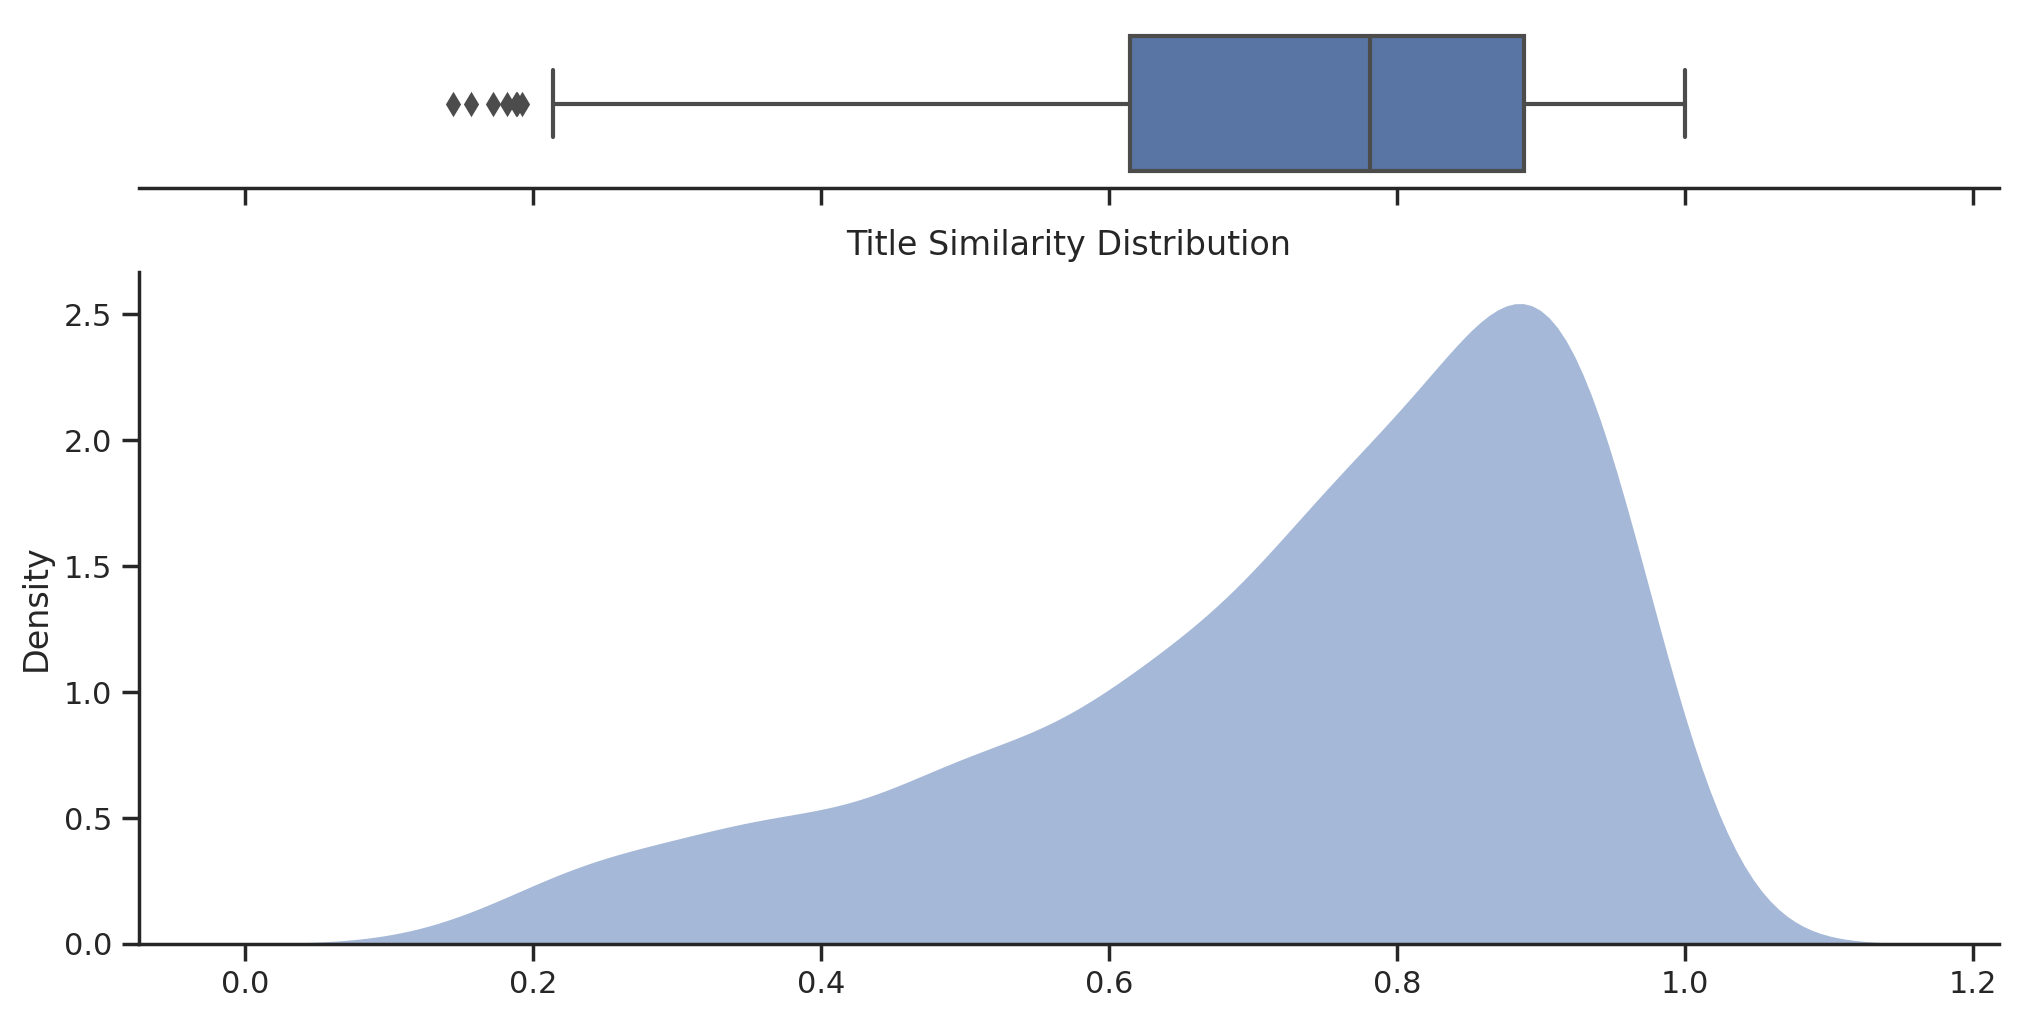

In [32]:
similarities = similarity_df["median_sim"].values

f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=(12, 6)
)

sns.boxplot(x=similarities, ax=ax_box)
sns.kdeplot(
    x=similarities,
    ax=ax_hist,
    fill=True,
    common_norm=False,
    palette="crest",
    alpha=0.5,
    linewidth=0,
)

ax_box.set(yticks=[])
ax_hist.set(title="Title Similarity Distribution")

sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [33]:
similarity_df["median_sim"].describe().round(2)

count    744.00
mean       0.73
std        0.20
min        0.14
25%        0.61
50%        0.78
75%        0.89
max        1.00
Name: median_sim, dtype: float64

We can see that the title similarity distribution skewed left. And it answers our first question.

### Dissimilar titles

Let's look at titles for which Russian translations doesn't convey meaning of the original name. 

In [34]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(
        similarity_df.iloc[:, :3].sort_values(by="median_sim", ascending=True).iloc[:50]
    )

,russian_title,original_title,median_sim
119,Одинокий волк,Clean,0.144
370,"Человек, который изменил всё",Moneyball,0.157
3,Борат,Borat: Cultural Learnings of America for Make ...,0.172
572,Однажды в Ирландии,The Guard,0.182
437,Философы: Урок выживания,After the Dark,0.188
541,Самый пьяный округ в мире,Lawless,0.189
484,По соображениям совести,Hacksaw Ridge,0.192
54,И грянул шторм,The Finest Hours,0.214
660,Монстры на каникулах,Hotel Transylvania,0.220
418,Ведьма,The VVitch: A New-England Folktale,0.220


There are a few cases for dissimilarity:  

**Russian title is a cropped version of original title**  
Another problem in this case can be the fact that embeddings don't work very well with proper names like Borat::Борат, Dolittle::Дулиттл, and so on.  
Examples:
* Борат::Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan
* Веном 2::Venom: Let There Be Carnage
* Бёрдмэн::Birdman or (The Unexpected Virtue of Ignorance)
* Амели::Le Fabuleux destin d'Amélie Poulain

**Russian title is an extended version of original title**  
(Remark about proper names applies to this case too)  
Examples:
* Удивительное путешествие доктора Дулиттла::Dolittle
* Пол: Секретный материальчик::Paul
* Рапунцель: Запутанная история::Tangled

**Russian title was localized (made up) by translators/localizers**  
Sometimes it is better to localize the title due to cultural and other peculiarities, but sometimes it goes too far.  
Examples:
* Невероятный мир глазами Энцо::The Art of Racing in the Rain
* Человек, который изменил всё::Moneyball
* Области тьмы::Limitless
* Одинокий волк::Clean

And it answers our second question.

### Similar titles

In [35]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(
        similarity_df.iloc[:, :3]
        .sort_values(by="median_sim", ascending=False)
        .iloc[:15]
    )

,russian_title,original_title,median_sim
33,1408,1408,1.000
690,2012,2012,1.000
621,X,X,1.000
207,365 дней,365 dni,0.998
211,Пожары,Incendies,0.985
402,Код 8,Code 8,0.981
253,Мама,Mama,0.980
538,Братья,Brothers,0.977
532,Три метра над уровнем неба,Tres metros sobre el cielo,0.972
727,Преступления будущего,Crimes of the Future,0.971


Similar titles are easier - they are almost literal translation of original titles. 

## Things to do

* Make good visualizations:
    * [Visualizing Embeddings With t-SNE](https://www.kaggle.com/code/colinmorris/visualizing-embeddings-with-t-sne/notebook)
* Add into comparison deleted titles 
For languages, where transcription is used instead of original title (hieroglyphs)
* Add new data (top-1000 series titles)